# Lineage Tracking for Cells in the Mother Machine

In [1]:
from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser import Visualiser
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML

### comment out ###
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

### Data Preparation
Load the properties of cells from a directory containing the csv files **only** or load it with paths to every single file

The cell properties data can be obtained from `skimage.measure.regionprops` on the masked trench images

In [2]:
directory = ".\\example\\csv"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack.from_path(directory)
print(exp)
display(exp.df.head(1))
# or
# filepath1 = ""
# filepath2 = ""
# ...
# exp = LineageTrack.from_path(filepath1, filepath2, ...)

Looking for data at these locations:
.\example\csv\2022_04_22_PC_data_epoch_20_prob_99.csv
.\example\csv\2022_04_22_RFP_data_epoch_20_prob_99.csv
.\example\csv\2022_04_22_YFP_data_epoch_20_prob_99.csv
Finished loading the data
(11859, 11)

                Read 3 files
                Channels: ['PC', 'YFP', 'mCherry']
                Properties for each cell: ['PC_intensity_mean', 'YFP_intensity_mean', 'area', 'centroid-0', 'centroid-1', 'label', 'mCherry_intensity_mean', 'major_axis_length', 'minor_axis_length', 'time_(mins)', 'trench_id']
            


,trench_id,time_(mins),label,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,PC_intensity_mean,mCherry_intensity_mean,YFP_intensity_mean
0,0,0,1,238,53.914722,7.221878,94.672272,65.420166,2048.146973,2647.348633,148.050415


### Tracking Algorithm: Strategy 3 on the Log Book

*Currently this algorithm is designed for exponential growth*

Model for cell growing: $L_{t+\Delta t} = L_t \times 2^{(\Delta t / \tau)}$

Model for one cell dividing during a time interval, Δt (very simplified and has big assumption): 
- Poisson distribution, $Pr(k|\lambda) = \frac{\lambda^k}{k!}e^{-\lambda}$
- $\lambda = \Delta t/T $
- Pr(divide) = Pr(k=1)
- Pr(no divide) = Pr(k=0)
- Assumptions: Division of a cell is independent of the previous division of the cell and its length; Division between cells are independent

#### STEP 1:
Estimate the growth time constant $\tau$, or the doubling time T, by observing the mother cell in some trenches (they can be the same thing but are measured in different ways here)

User need to select the period, e.g., exponential growth

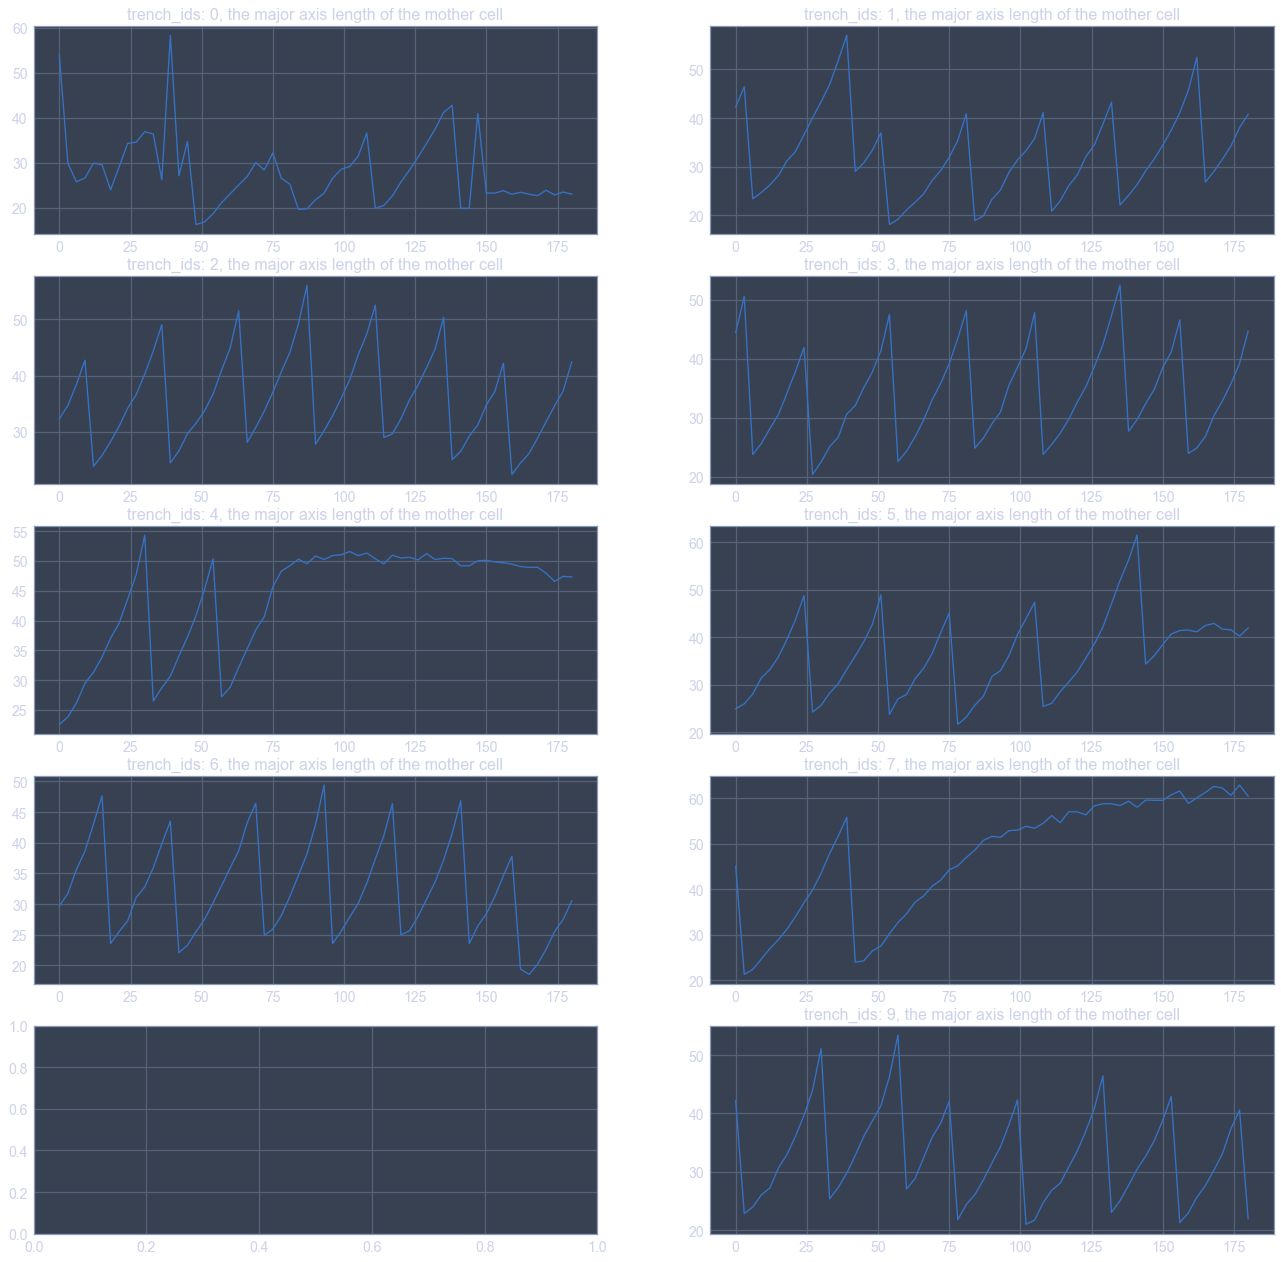

In [3]:
trench_list = [i for i in range(10)]

m = exp.get_mother_cell_growth(trench_list, plot=True)

Find the division times for trench 1

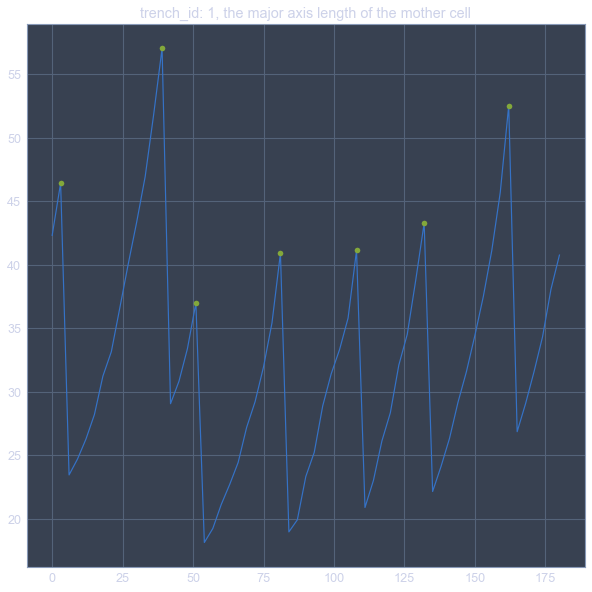

[[  3.          46.41300583]
 [ 39.          57.02418137]
 [ 51.          36.97775269]
 [ 81.          40.89678574]
 [108.          41.11452484]
 [132.          43.26797485]
 [162.          52.50556564]]


In [4]:
mcell1, idx1 = exp.find_division(1)

peaks = [mcell1[1][i, :] for i in idx1]
peaks = np.array(peaks)
print(peaks)

Select the peaks between the exponential growth phase, calculate intervals between division and for each interval, estimate the growth constant

> NOTE: the peak could also be lysis

the slope is estimated to be 0.038872735918546425
the intercept is estimated to be 4.501272528268139


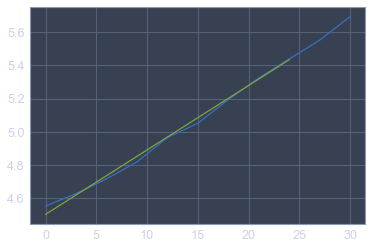

the slope is estimated to be 0.033439747875788996
the intercept is estimated to be 4.855506304192734


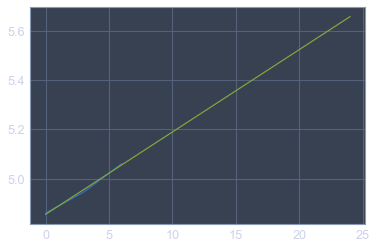

the slope is estimated to be 0.04031699186300881
the intercept is estimated to be 4.153692489401551


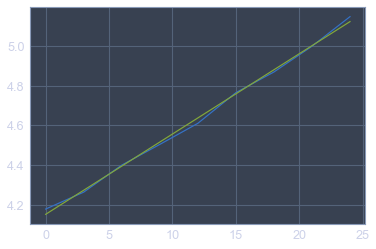

the slope is estimated to be 0.04608023245107278
the intercept is estimated to be 4.2417947414170545


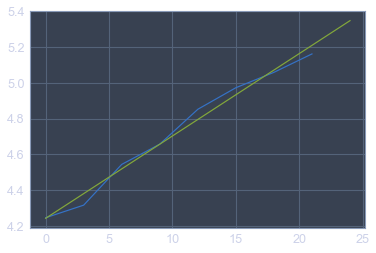

the slope is estimated to be 0.0493229777528664
the intercept is estimated to be 4.388885019014377


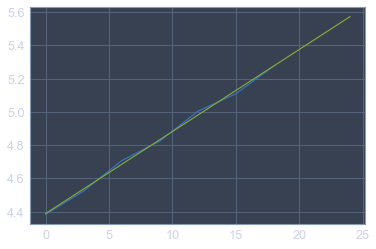

the slope is estimated to be 0.04304354489620594
the intercept is estimated to be 4.465180328222813


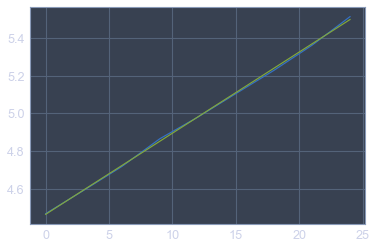

In [5]:
# since we are interested in  exponential growth, slice it according to the data
# in this case data between every peaks can be used
e_phase_idx1 = idx1[:]

exp.collect_model_para(mcell1, e_phase_idx1, plot=True)

In [6]:
print(exp.div_intervals)
print(exp.growth_taus)
print(exp.length_at_div)

[36.0, 12.0, 30.0, 27.0, 24.0, 30.0]
[0.038872735918546425, 0.033439747875788996, 0.04031699186300881, 0.04608023245107278, 0.0493229777528664, 0.04304354489620594]
[[[3.0, 39.0, 51.0, 81.0, 108.0, 132.0, 162.0], [46.41300582885742, 57.0241813659668, 36.977752685546875, 40.896785736083984, 41.114524841308594, 43.267974853515625, 52.50556564331055]]]


Repeat for trench 2, and so on

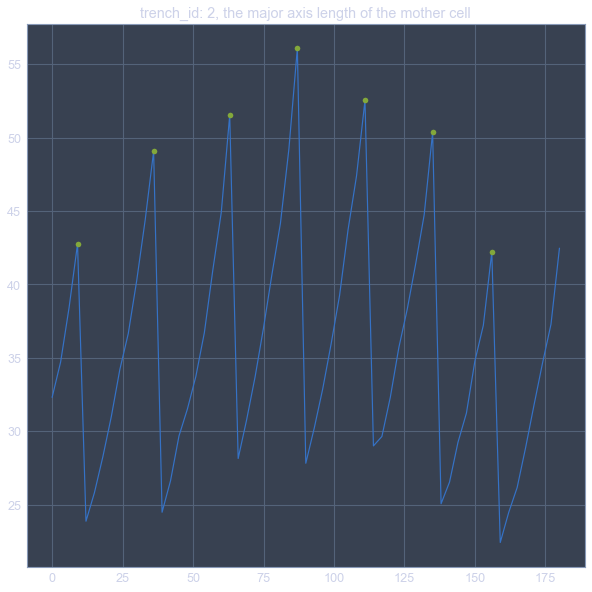

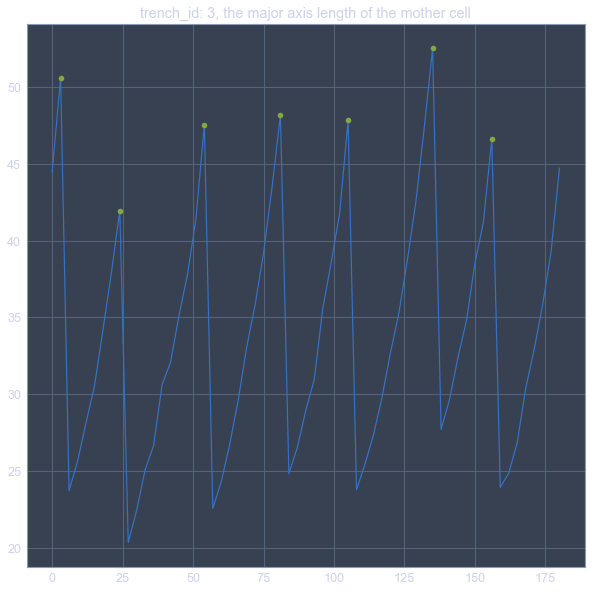

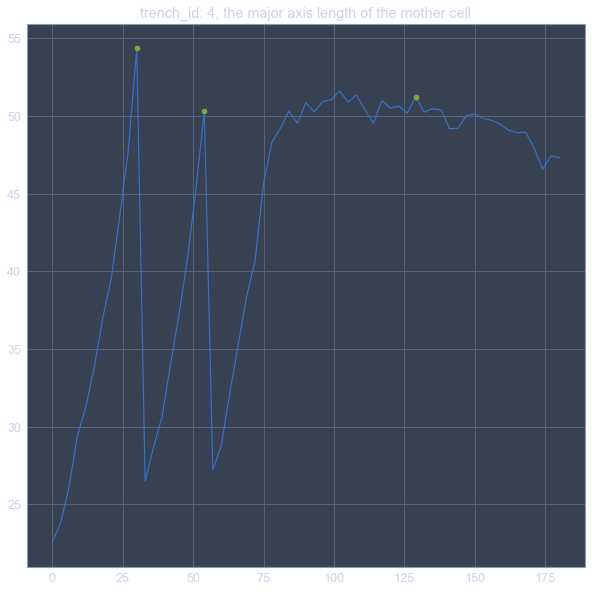

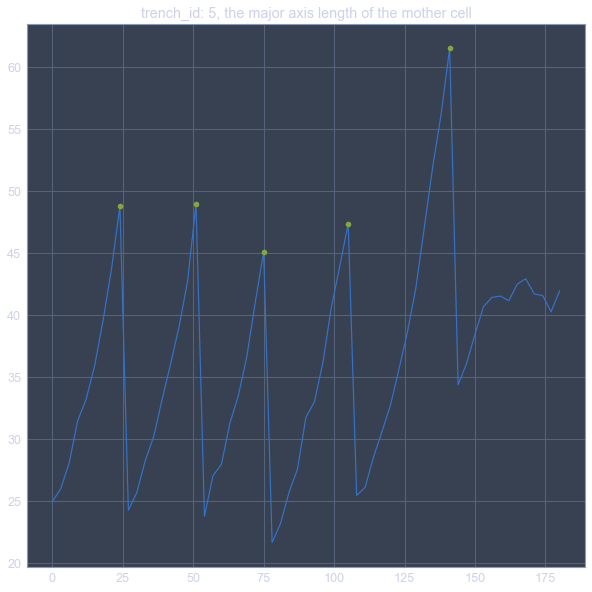

In [7]:
mcell2, idx2 = exp.find_division(2)
mcell3, idx3 = exp.find_division(3)
mcell4, idx4 = exp.find_division(4)
mcell5, idx5 = exp.find_division(5)

In [8]:
exp.collect_model_para(mcell2, idx2[:])
exp.collect_model_para(mcell3, idx3[:])
# slice it according to the data
e_phase_idx4 = idx4[:-1]    # do not use the last peak
exp.collect_model_para(mcell4, e_phase_idx4)
# this is just to show that collect_model_para only need to be run once for each mother cell
exp.collect_model_para(mcell4, e_phase_idx4)
exp.collect_model_para(mcell5, idx5[:])

In [9]:
exp.update_model_para(model="unif")


                    The average time interval for division is 26.08695652173913
                    The time constant for exponential growth is 23.95156924600458
                    The average division length is 48.36530671800886 with variance 29.00931377076993
                    


For some cases where you might want to set the parameters manually, e.g., mother cells are not representative of the whole population or cells are growing heterogeneously. Use:

`self.div_interval = some value` - used for setting up prior probability

or, 

`self.growth_tau = some value` - used for estimating the growth of the cells length

Tools to select mode of modelling will be developed later

To include the cells' length into our prior, esimate Gaussian cdf parameters. This is done in `update_model_para()`, but can also set manually by `self.div_length_para = (mean, var)`

$Pr(div | \lambda, length) = \frac{Pr(div, \lambda, length)}{Pr(length)Pr(\lambda)}$

Since length and $\lambda$ can be assumed to be independent, $Pr(div | \lambda, length) \propto Pr(div|\lambda) Pr(div|length)$

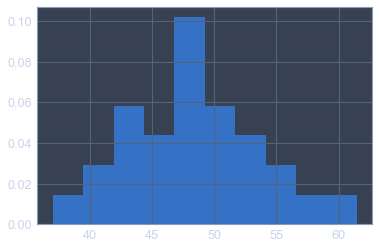

[46.41300582885742, 57.0241813659668, 36.977752685546875, 40.896785736083984, 41.114524841308594, 43.267974853515625, 52.50556564331055, 42.7536735534668, 49.063812255859375, 51.52674865722656, 56.0760383605957, 52.529659271240234, 50.35191345214844, 42.20262145996094, 50.5936164855957, 41.95100402832031, 47.537174224853516, 48.16990280151367, 47.82967758178711, 52.50795364379883, 46.605934143066406, 54.354766845703125, 50.34778594970703, 48.754451751708984, 48.92498016357422, 45.09147262573242, 47.36546325683594, 61.49014663696289]


In [10]:
import matplotlib.pyplot as plt

max_lengths = []
for i in exp.length_at_div:
    max_lengths += i[1]
plt.hist(max_lengths, density=True)
plt.show()
print(max_lengths)

In [11]:
exp.div_length_paras

(48.36530671800886, 29.00931377076993)

#### STEP 2:
For each frame in each trench, look at the current frame in the trench and predict a list of furture of the cells in the next frame with some probability (prior) by using the model from above: growth and division. 

Score each furture with a likelihood function, using y position and length. Select the one with the highest value of prior x likelihood. 

Can square the likelihood to diminish the effect of prior since the prior has not considered the dependence between divisions. 

**Interested cell's properties**
- Label: only consider the several cells at the top of the trench, the order is consistent
- Major axis length: relevant to cell growth, cell division
- Centroid y coordinates: relevant to cell growth and also the growth of all the previous cells

Since they are geometrical properties, I have decided to not normalise the features.

Run `track_trench` for specified trench, this function can have the following arguments:
- `trench` is the trench_id the track the cells
- `threshold` is the limit of the centroid y axis - this is to limit the number of cells to look at in each trench
- `max_dpf` is the maximum division per frame to simulate, 1 or 2 should be enough but in principle this value can go up to the total number of cells below the threshold, i.e. all cells divide. If it goes over the total number of cells it will instead use the total number.
- `mode` is to select the method used to search the cells' matching future, options are simple nearest neighbour 'KDTree' or sequence matching 'SeqMatch' (exclusively one-to-one matching, suggested)
- `p_sp` is the probability of all cells entering stationary phase (stop growing), default 0
- `show_details` will display details of the simulation if set to True, default False
- `ret_df` will return a pandas dataframe rather than a dictionary if set to True, default False

In [12]:
track_df, lysis_df = exp.track_trench(trench=1, threshold=250, max_dpf=3, show_details=True, ret_df=True)

Tracking over frames:   3%|████▎                                                                                                                           | 2/60 [00:00<00:06,  8.95it/s]

looking at cells: 
cell in trench 1.0 at 0.0 min with label 1.0
cell in trench 1.0 at 0.0 min with label 2.0
cell in trench 1.0 at 0.0 min with label 3.0
cell in trench 1.0 at 0.0 min with label 4.0
cell in trench 1.0 at 0.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.23969005937653357
score: 2.135902718073851e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 4.841916504423681e-07
score: 1.1990841596634677e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 4.6996756100017117e-08
score: 4.3703431674284196e-12
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0709770306623936
score: 0.001713750283290321
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Gro

Tracking over frames:   8%|██████████▋                                                                                                                     | 5/60 [00:00<00:07,  7.05it/s]

looking at cells: 
cell in trench 1.0 at 9.0 min with label 1.0
cell in trench 1.0 at 9.0 min with label 2.0
cell in trench 1.0 at 9.0 min with label 3.0
cell in trench 1.0 at 9.0 min with label 4.0
cell in trench 1.0 at 9.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5343131177255113
score: 0.06751624931064289
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 2.4283061485874454e-05
score: 7.489091583137061e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.00012594114249769056
score: 3.40164527910093e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 5.155788769700269e-06
score: 1.782433838129856e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Grow

Tracking over frames:  12%|██████████████▉                                                                                                                 | 7/60 [00:00<00:07,  7.03it/s]

looking at cells: 
cell in trench 1.0 at 15.0 min with label 1.0
cell in trench 1.0 at 15.0 min with label 2.0
cell in trench 1.0 at 15.0 min with label 3.0
cell in trench 1.0 at 15.0 min with label 4.0
cell in trench 1.0 at 15.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5256802407599959
score: 0.297223072510165
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0008322190319166539
score: 2.316009620136075e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.004188417184755669
score: 0.0023681586791386043
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00026171266510622996
score: 7.687491585505843e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Gr

Tracking over frames:  15%|███████████████████▏                                                                                                            | 9/60 [00:01<00:05,  9.21it/s]

score: 1.2516864505704542e-05
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Divided!']
with probability: 8.162506962283312e-07
score: 1.1214540082365215e-10
the simulated scenario: ['Divided!', 'Divided!', 'Divided!', 'Growing']
with probability: 7.357128369914014e-06
score: 1.913080728588083e-09
the simulated scenario: ['Growing', 'Divided!', 'Divided!', 'Divided!']
with probability: 7.0846104229051985e-06
score: 7.343159903554853e-09
the simulated scenario: ['Divided!', 'Growing', 'Divided!', 'Divided!']
with probability: 4.973032383949136e-06
score: 2.080924304003145e-09
RESULT:
0.00112157700427469
['Growing', 'Growing', 'Divided!', 'Growing']


looking at cells: 
cell in trench 1.0 at 27.0 min with label 1.0
cell in trench 1.0 at 27.0 min with label 2.0
cell in trench 1.0 at 27.0 min with label 3.0
cell in trench 1.0 at 27.0 min with label 4.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing'

Tracking over frames:  20%|█████████████████████████▍                                                                                                     | 12/60 [00:01<00:06,  7.34it/s]

looking at cells: 
cell in trench 1.0 at 30.0 min with label 1.0
cell in trench 1.0 at 30.0 min with label 2.0
cell in trench 1.0 at 30.0 min with label 3.0
cell in trench 1.0 at 30.0 min with label 4.0
cell in trench 1.0 at 30.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.30958490008396106
score: 0.007929088030678613
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 1.250493282530538e-07
score: 4.692339387995538e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 5.556802022959497e-07
score: 1.8745708818862057e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.667990131289897e-07
score: 1.360909596405875e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!'

Tracking over frames:  23%|█████████████████████████████▋                                                                                                 | 14/60 [00:01<00:07,  6.34it/s]

looking at cells: 
cell in trench 1.0 at 36.0 min with label 1.0
cell in trench 1.0 at 36.0 min with label 2.0
cell in trench 1.0 at 36.0 min with label 3.0
cell in trench 1.0 at 36.0 min with label 4.0
cell in trench 1.0 at 36.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.03523307390723387
score: 0.0020781606289314446
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 3.853893766238796e-07
score: 1.1877363195299383e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 8.366443867862983e-06
score: 4.934799131105048e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.7455622778293949e-06
score: 4.664735571797959e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided

Tracking over frames:  25%|███████████████████████████████▊                                                                                               | 15/60 [00:02<00:08,  5.26it/s]

looking at cells: 
cell in trench 1.0 at 42.0 min with label 1.0
cell in trench 1.0 at 42.0 min with label 2.0
cell in trench 1.0 at 42.0 min with label 3.0
cell in trench 1.0 at 42.0 min with label 4.0
cell in trench 1.0 at 42.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5252131364093847
score: 0.022660564480746315
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0022528360445494477
score: 4.419969528963366e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.002516149535938302
score: 4.481578566170824e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00011663806427512585
score: 3.5597635708754335e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!',

Tracking over frames:  27%|█████████████████████████████████▊                                                                                             | 16/60 [00:02<00:08,  4.94it/s]

looking at cells: 
cell in trench 1.0 at 45.0 min with label 1.0
cell in trench 1.0 at 45.0 min with label 2.0
cell in trench 1.0 at 45.0 min with label 3.0
cell in trench 1.0 at 45.0 min with label 4.0
cell in trench 1.0 at 45.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4934650333855483
score: 0.04190630616601195
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00846863571233451
score: 1.5381978184354352e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.012129579256225808
score: 1.9875090666377718e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0002455129501739435
score: 6.010401165325639e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'G

Tracking over frames:  30%|██████████████████████████████████████                                                                                         | 18/60 [00:02<00:08,  4.96it/s]

looking at cells: 
cell in trench 1.0 at 48.0 min with label 1.0
cell in trench 1.0 at 48.0 min with label 2.0
cell in trench 1.0 at 48.0 min with label 3.0
cell in trench 1.0 at 48.0 min with label 4.0
cell in trench 1.0 at 48.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3599538950429973
score: 0.007796452905973701
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.03324028888867274
score: 3.909866713970056e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.04417715272086637
score: 0.0009568589073528438
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.001202847244698021
score: 2.0835345447506702e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Gro

Tracking over frames:  32%|████████████████████████████████████████▏                                                                                      | 19/60 [00:03<00:12,  3.36it/s]

looking at cells: 
cell in trench 1.0 at 54.0 min with label 1.0
cell in trench 1.0 at 54.0 min with label 2.0
cell in trench 1.0 at 54.0 min with label 3.0
cell in trench 1.0 at 54.0 min with label 4.0
cell in trench 1.0 at 54.0 min with label 5.0
cell in trench 1.0 at 54.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.40347972986359393
score: 0.005880410262504369
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.051226809987071284
score: 5.7138405150694156e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 7.855277945699075e-08
score: 2.6839732438008164e-10
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.672416312232886e-08
s

Tracking over frames:  33%|██████████████████████████████████████████▎                                                                                    | 20/60 [00:03<00:11,  3.50it/s]

score: 1.1919683206306309e-14
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!', 'Growing']
with probability: 6.776219675513806e-13
score: 4.2430619129769796e-16
the simulated scenario: ['Growing', 'Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 2.843617871981034e-08
score: 1.0517348893315034e-11
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.5719069167856613e-13
score: 1.4899062543755298e-16
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!', 'Divided!']
with probability: 2.0592091782596784e-18
score: 9.709687885485794e-22
the simulated scenario: ['Divided!', 'Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 6.505013997958905e-16
score: 2.2493795618603573e-19
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Divided!', 'Divided!']
with probability: 1.978502293535694e-12
score: 5.760049378163142e-16
the simulated scenario: ['Divided!', 'Growing', 'Growin

Tracking over frames:  35%|████████████████████████████████████████████▍                                                                                  | 21/60 [00:03<00:11,  3.48it/s]

looking at cells: 
cell in trench 1.0 at 60.0 min with label 1.0
cell in trench 1.0 at 60.0 min with label 2.0
cell in trench 1.0 at 60.0 min with label 3.0
cell in trench 1.0 at 60.0 min with label 4.0
cell in trench 1.0 at 60.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.10729767126240151
score: 0.00010463195268850633
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.2675249866548382
score: 0.00010919937582261971
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 1.0367648130257259e-05
score: 6.662450362674941e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 6.946584832969457e-07
score: 5.199688624322049e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!'

Tracking over frames:  37%|██████████████████████████████████████████████▌                                                                                | 22/60 [00:04<00:11,  3.40it/s]

looking at cells: 
cell in trench 1.0 at 63.0 min with label 1.0
cell in trench 1.0 at 63.0 min with label 2.0
cell in trench 1.0 at 63.0 min with label 3.0
cell in trench 1.0 at 63.0 min with label 4.0
cell in trench 1.0 at 63.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.039030144997460735
score: 0.0010011873646045143
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.30964333034750297
score: 0.00022766802314827165
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 4.491178856052277e-05
score: 8.538058484940945e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 7.638875679280717e-07
score: 1.7502606035859042e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!

Tracking over frames:  42%|████████████████████████████████████████████████████▉                                                                          | 25/60 [00:04<00:08,  4.23it/s]

looking at cells: 
cell in trench 1.0 at 69.0 min with label 1.0
cell in trench 1.0 at 69.0 min with label 2.0
cell in trench 1.0 at 69.0 min with label 3.0
cell in trench 1.0 at 69.0 min with label 4.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 2.5615043319219913e-05
score: 1.522793339905597e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 2.0623049026653233e-07
score: 4.3074468592600294e-10
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 5.714504930520952e-08
score: 1.102168900112423e-10
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.2728685489931848e-09
score: 2.378526123940989e-12
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.2973571446525929
score: 0.00018074573469612206
the simulated scenari

Tracking over frames:  45%|█████████████████████████████████████████████████████████▏                                                                     | 27/60 [00:05<00:08,  4.11it/s]

looking at cells: 
cell in trench 1.0 at 75.0 min with label 1.0
cell in trench 1.0 at 75.0 min with label 2.0
cell in trench 1.0 at 75.0 min with label 3.0
cell in trench 1.0 at 75.0 min with label 4.0
cell in trench 1.0 at 75.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3002379370008188
score: 0.015625194985338323
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00807948770095754
score: 1.4022636271215476e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.06028695669259252
score: 0.003137496423018109
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.030262752923980327
score: 4.4141089677546865e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Gro

Tracking over frames:  47%|███████████████████████████████████████████████████████████▎                                                                   | 28/60 [00:05<00:07,  4.42it/s]

looking at cells: 
cell in trench 1.0 at 81.0 min with label 1.0
cell in trench 1.0 at 81.0 min with label 2.0
cell in trench 1.0 at 81.0 min with label 3.0
cell in trench 1.0 at 81.0 min with label 4.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.29312184835056093
score: 2.86834957685922e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.083065086744295
score: 1.0080678243614612e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 5.239484596162942e-08
score: 9.837149091296876e-12
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.04703961867635317
score: 0.00023691332452072255
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.4210209429190674e-06
score: 2.3306409939710934e-10
the simulated scenario: ['Gr

Tracking over frames:  48%|█████████████████████████████████████████████████████████████▍                                                                 | 29/60 [00:05<00:07,  4.32it/s]

looking at cells: 
cell in trench 1.0 at 84.0 min with label 1.0
cell in trench 1.0 at 84.0 min with label 2.0
cell in trench 1.0 at 84.0 min with label 3.0
cell in trench 1.0 at 84.0 min with label 4.0
cell in trench 1.0 at 84.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.37476360733608405
score: 0.00014506848081558091
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 4.916093096286636e-07
score: 2.5232129560473912e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.10007431984973397
score: 2.890731087368071e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.4732610437011742e-08
score: 5.610093888989578e-13
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!

Tracking over frames:  50%|███████████████████████████████████████████████████████████████▌                                                               | 30/60 [00:06<00:09,  3.25it/s]

looking at cells: 
cell in trench 1.0 at 87.0 min with label 1.0
cell in trench 1.0 at 87.0 min with label 2.0
cell in trench 1.0 at 87.0 min with label 3.0
cell in trench 1.0 at 87.0 min with label 4.0
cell in trench 1.0 at 87.0 min with label 5.0
cell in trench 1.0 at 87.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.2973527644936698
score: 0.0020948210071058465
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.6591115772327454e-06
score: 6.4087429496010835e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 5.1030120485124e-08
score: 1.0590908369135609e-10
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 8.399463241792941e-08
s

Tracking over frames:  52%|█████████████████████████████████████████████████████████████████▌                                                             | 31/60 [00:06<00:09,  3.07it/s]

looking at cells: 
cell in trench 1.0 at 90.0 min with label 1.0
cell in trench 1.0 at 90.0 min with label 2.0
cell in trench 1.0 at 90.0 min with label 3.0
cell in trench 1.0 at 90.0 min with label 4.0
cell in trench 1.0 at 90.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4130263165248699
score: 0.010042203829996321
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 5.93533369320503e-05
score: 1.2341397683862465e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.07536057123696804
score: 0.00014878577864516
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.0077433593207794e-06
score: 2.7153942460823003e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'G

Tracking over frames:  55%|█████████████████████████████████████████████████████████████████████▊                                                         | 33/60 [00:07<00:07,  3.44it/s]

looking at cells: 
cell in trench 1.0 at 93.0 min with label 1.0
cell in trench 1.0 at 93.0 min with label 2.0
cell in trench 1.0 at 93.0 min with label 3.0
cell in trench 1.0 at 93.0 min with label 4.0
cell in trench 1.0 at 93.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3973275931015991
score: 0.00010000179480444415
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0003772050274482777
score: 1.0331236535388227e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.08172872795183989
score: 2.446695050202849e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 9.08595738693237e-06
score: 2.286808321358131e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 

Tracking over frames:  57%|███████████████████████████████████████████████████████████████████████▉                                                       | 34/60 [00:07<00:07,  3.34it/s]

looking at cells: 
cell in trench 1.0 at 99.0 min with label 1.0
cell in trench 1.0 at 99.0 min with label 2.0
cell in trench 1.0 at 99.0 min with label 3.0
cell in trench 1.0 at 99.0 min with label 4.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4907371706298654
score: 7.823180913437053e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.03772074490321508
score: 5.702888040182077e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00028456257150773396
score: 5.952754810261271e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0010792273750650809
score: 2.7390048364258486e-07
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.015874413566052077
score: 2.545831323516285e-06
the simulated scenario: ['G

Tracking over frames:  58%|██████████████████████████████████████████████████████████████████████████                                                     | 35/60 [00:07<00:07,  3.56it/s]

looking at cells: 
cell in trench 1.0 at 102.0 min with label 1.0
cell in trench 1.0 at 102.0 min with label 2.0
cell in trench 1.0 at 102.0 min with label 3.0
cell in trench 1.0 at 102.0 min with label 4.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.2369609717516829
score: 0.026285009903877124
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.11802249261990501
score: 0.013091701829469882
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.001012626801485833
score: 2.3116981405169123e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.001542995781287144
score: 1.2773615994696529e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0302887654070235
score: 4.1911223252995035e-05
the simulated scenario: ['Gr

Tracking over frames:  62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 37/60 [00:08<00:05,  4.31it/s]

looking at cells: 
cell in trench 1.0 at 108.0 min with label 1.0
cell in trench 1.0 at 108.0 min with label 2.0
cell in trench 1.0 at 108.0 min with label 3.0
cell in trench 1.0 at 108.0 min with label 4.0
cell in trench 1.0 at 108.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.32759199886104545
score: 2.0290634678020375e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 3.262592240692142e-07
score: 2.1071759626827512e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 1.1871939042577686e-05
score: 7.745202971014543e-10
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.04371001146281938
score: 6.040141348310697e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Div

Tracking over frames:  63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 38/60 [00:08<00:05,  3.87it/s]

looking at cells: 
cell in trench 1.0 at 111.0 min with label 1.0
cell in trench 1.0 at 111.0 min with label 2.0
cell in trench 1.0 at 111.0 min with label 3.0
cell in trench 1.0 at 111.0 min with label 4.0
cell in trench 1.0 at 111.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.22402107478356892
score: 2.928915492943857e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.1944834849668291
score: 0.001050639002776607
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 1.7312591862778721e-06
score: 1.8611749331500224e-10
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 4.7866938827114125e-09
score: 1.0878328248148575e-13
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divi

Tracking over frames:  65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 39/60 [00:09<00:07,  2.93it/s]

looking at cells: 
cell in trench 1.0 at 114.0 min with label 1.0
cell in trench 1.0 at 114.0 min with label 2.0
cell in trench 1.0 at 114.0 min with label 3.0
cell in trench 1.0 at 114.0 min with label 4.0
cell in trench 1.0 at 114.0 min with label 5.0
cell in trench 1.0 at 114.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47157730737847986
score: 0.0054458398343471956
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 8.867960857183737e-07
score: 1.7843140761329002e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 9.80993982151224e-08
score: 2.324611165553615e-10
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 2.772473146311295

Tracking over frames:  67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 40/60 [00:09<00:07,  2.61it/s]

looking at cells: 
cell in trench 1.0 at 117.0 min with label 1.0
cell in trench 1.0 at 117.0 min with label 2.0
cell in trench 1.0 at 117.0 min with label 3.0
cell in trench 1.0 at 117.0 min with label 4.0
cell in trench 1.0 at 117.0 min with label 5.0
cell in trench 1.0 at 117.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47068872869503225
score: 0.02319130025861886
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.154756397478682e-05
score: 3.3962382810083775e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 7.877783596360845e-07
score: 2.763296153703272e-09
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 3.947359181755494e

Tracking over frames:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 41/60 [00:10<00:08,  2.22it/s]

looking at cells: 
cell in trench 1.0 at 120.0 min with label 1.0
cell in trench 1.0 at 120.0 min with label 2.0
cell in trench 1.0 at 120.0 min with label 3.0
cell in trench 1.0 at 120.0 min with label 4.0
cell in trench 1.0 at 120.0 min with label 5.0
cell in trench 1.0 at 120.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4635318016714779
score: 0.016248829018474298
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 9.904590393479106e-05
score: 2.161925663490469e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 6.6843643791449675e-06
score: 1.7738948708180422e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.000207546369322

Tracking over frames:  70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 42/60 [00:10<00:07,  2.29it/s]

looking at cells: 
cell in trench 1.0 at 123.0 min with label 1.0
cell in trench 1.0 at 123.0 min with label 2.0
cell in trench 1.0 at 123.0 min with label 3.0
cell in trench 1.0 at 123.0 min with label 4.0
cell in trench 1.0 at 123.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5134594341936316
score: 0.01261068019068535
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0009143318080915046
score: 1.7433476677059119e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.009947319190602487
score: 1.52974885111499e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 6.678281685056643e-05
score: 1.4236056049904312e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided

Tracking over frames:  72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 43/60 [00:11<00:07,  2.35it/s]

looking at cells: 
cell in trench 1.0 at 126.0 min with label 1.0
cell in trench 1.0 at 126.0 min with label 2.0
cell in trench 1.0 at 126.0 min with label 3.0
cell in trench 1.0 at 126.0 min with label 4.0
cell in trench 1.0 at 126.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.42801916398780954
score: 0.00050649655319209
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.003312708581915756
score: 1.388857757833298e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.05409988155934903
score: 0.0018286066199462033
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0003213916363472102
score: 1.4783446983419307e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!

Tracking over frames:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 44/60 [00:11<00:07,  2.23it/s]

looking at cells: 
cell in trench 1.0 at 129.0 min with label 1.0
cell in trench 1.0 at 129.0 min with label 2.0
cell in trench 1.0 at 129.0 min with label 3.0
cell in trench 1.0 at 129.0 min with label 4.0
cell in trench 1.0 at 129.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.41212019698473
score: 4.511432281584988e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.02864778129246128
score: 0.0009327102435275207
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 1.6352086264731298e-07
score: 1.7276462052745883e-11
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.002213111381783668
score: 1.6826367419636708e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided

Tracking over frames:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 45/60 [00:11<00:06,  2.36it/s]

looking at cells: 
cell in trench 1.0 at 132.0 min with label 1.0
cell in trench 1.0 at 132.0 min with label 2.0
cell in trench 1.0 at 132.0 min with label 3.0
cell in trench 1.0 at 132.0 min with label 4.0
cell in trench 1.0 at 132.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.28490966408962
score: 6.458789145580393e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 5.899318089848384e-08
score: 2.5473803347437366e-12
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.007240600958373605
score: 1.6789630295778538e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.01017277616685805
score: 8.648029688031809e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!

Tracking over frames:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 46/60 [00:12<00:08,  1.69it/s]

looking at cells: 
cell in trench 1.0 at 135.0 min with label 1.0
cell in trench 1.0 at 135.0 min with label 2.0
cell in trench 1.0 at 135.0 min with label 3.0
cell in trench 1.0 at 135.0 min with label 4.0
cell in trench 1.0 at 135.0 min with label 5.0
cell in trench 1.0 at 135.0 min with label 6.0
cell in trench 1.0 at 135.0 min with label 7.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3383742405325162
score: 0.002326318328773185
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.030091777980648e-07
score: 2.1481232123673133e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.942158052656028e-08
score: 5.081432269056106e-11
the simulated scenario: ['Divided!', 'Grow

Tracking over frames:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 47/60 [00:13<00:08,  1.62it/s]

looking at cells: 
cell in trench 1.0 at 138.0 min with label 1.0
cell in trench 1.0 at 138.0 min with label 2.0
cell in trench 1.0 at 138.0 min with label 3.0
cell in trench 1.0 at 138.0 min with label 4.0
cell in trench 1.0 at 138.0 min with label 5.0
cell in trench 1.0 at 138.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47162986510799515
score: 0.032572816092845784
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 6.210721224818567e-08
score: 2.6569326583891366e-10
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 6.453485331609197e-07
score: 2.3868998152324284e-09
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 7.49359688568802

Tracking over frames:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 48/60 [00:14<00:07,  1.57it/s]

looking at cells: 
cell in trench 1.0 at 141.0 min with label 1.0
cell in trench 1.0 at 141.0 min with label 2.0
cell in trench 1.0 at 141.0 min with label 3.0
cell in trench 1.0 at 141.0 min with label 4.0
cell in trench 1.0 at 141.0 min with label 5.0
cell in trench 1.0 at 141.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.471454832668834
score: 0.008706653279828275
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.8834093859910917e-07
score: 1.0648326665172355e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 7.383472939230484e-06
score: 1.6921307713942182e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 4.671195403149592

Tracking over frames:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 49/60 [00:15<00:07,  1.49it/s]

looking at cells: 
cell in trench 1.0 at 144.0 min with label 1.0
cell in trench 1.0 at 144.0 min with label 2.0
cell in trench 1.0 at 144.0 min with label 3.0
cell in trench 1.0 at 144.0 min with label 4.0
cell in trench 1.0 at 144.0 min with label 5.0
cell in trench 1.0 at 144.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4704193375334512
score: 0.03671135994030848
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 5.359581372416743e-06
score: 1.7670290290055602e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 3.853201474643876e-05
score: 1.0851371266326116e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0003725596600370

Tracking over frames:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 50/60 [00:15<00:05,  1.73it/s]

looking at cells: 
cell in trench 1.0 at 147.0 min with label 1.0
cell in trench 1.0 at 147.0 min with label 2.0
cell in trench 1.0 at 147.0 min with label 3.0
cell in trench 1.0 at 147.0 min with label 4.0
cell in trench 1.0 at 147.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5296541044590152
score: 0.08134609613701568
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 2.635795156713577e-05
score: 8.899408129310283e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0008458417769559754
score: 2.0537821891332114e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0005450826458763118
score: 1.4447957080729562e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divid

Tracking over frames:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 51/60 [00:15<00:04,  1.91it/s]

looking at cells: 
cell in trench 1.0 at 150.0 min with label 1.0
cell in trench 1.0 at 150.0 min with label 2.0
cell in trench 1.0 at 150.0 min with label 3.0
cell in trench 1.0 at 150.0 min with label 4.0
cell in trench 1.0 at 150.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5089762585310272
score: 0.12288100918344855
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00017929073719311534
score: 5.244853878749892e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.005998885732135549
score: 0.001448297676729592
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0020695562392223413
score: 4.806667205583559e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!

Tracking over frames:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 53/60 [00:16<00:02,  2.61it/s]

looking at cells: 
cell in trench 1.0 at 153.0 min with label 1.0
cell in trench 1.0 at 153.0 min with label 2.0
cell in trench 1.0 at 153.0 min with label 3.0
cell in trench 1.0 at 153.0 min with label 4.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5347017786865922
score: 0.027092086286575966
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0014572835232847462
score: 2.985626081274985e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00791935230209768
score: 1.2455723269578255e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.024181237707425456
score: 1.0568987605894486e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.001088750809476835
score: 2.1047672649592106e-06
the simulated scenario: 

Tracking over frames:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 54/60 [00:16<00:02,  2.47it/s]

looking at cells: 
cell in trench 1.0 at 159.0 min with label 1.0
cell in trench 1.0 at 159.0 min with label 2.0
cell in trench 1.0 at 159.0 min with label 3.0
cell in trench 1.0 at 159.0 min with label 4.0
cell in trench 1.0 at 159.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.14453648393632318
score: 1.6005249118714447e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 1.6722947842942704e-08
score: 6.573581337365791e-13
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.011588900103043748
score: 2.187688270771614e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.6096305584165555e-08
score: 5.313511149229615e-13
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Di

Tracking over frames:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 55/60 [00:17<00:02,  2.12it/s]

looking at cells: 
cell in trench 1.0 at 162.0 min with label 1.0
cell in trench 1.0 at 162.0 min with label 2.0
cell in trench 1.0 at 162.0 min with label 3.0
cell in trench 1.0 at 162.0 min with label 4.0
cell in trench 1.0 at 162.0 min with label 5.0
cell in trench 1.0 at 162.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.02319467165891778
score: 1.9346039477531056e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.3083081658451446e-08
score: 1.3275644593136732e-12
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.919094916769008e-08
score: 7.842937308592073e-13
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.337020821676

Tracking over frames:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 56/60 [00:18<00:02,  1.42it/s]

looking at cells: 
cell in trench 1.0 at 165.0 min with label 1.0
cell in trench 1.0 at 165.0 min with label 2.0
cell in trench 1.0 at 165.0 min with label 3.0
cell in trench 1.0 at 165.0 min with label 4.0
cell in trench 1.0 at 165.0 min with label 5.0
cell in trench 1.0 at 165.0 min with label 6.0
cell in trench 1.0 at 165.0 min with label 7.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4160359885690586
score: 0.001600303877819274
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.077627131360104e-06
score: 1.398858680672678e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.1468926479164905e-06
score: 4.49096754082283e-09
the simulated scenario: ['Divided!', 'Growi

Tracking over frames:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 57/60 [00:19<00:02,  1.47it/s]

looking at cells: 
cell in trench 1.0 at 168.0 min with label 1.0
cell in trench 1.0 at 168.0 min with label 2.0
cell in trench 1.0 at 168.0 min with label 3.0
cell in trench 1.0 at 168.0 min with label 4.0
cell in trench 1.0 at 168.0 min with label 5.0
cell in trench 1.0 at 168.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47105087868303375
score: 0.013866016867007567
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.3970633323525786e-05
score: 7.551857239419779e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.584888454174e-05
score: 3.6890535933625804e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.00035125731592266

Tracking over frames:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 58/60 [00:19<00:01,  1.51it/s]

looking at cells: 
cell in trench 1.0 at 171.0 min with label 1.0
cell in trench 1.0 at 171.0 min with label 2.0
cell in trench 1.0 at 171.0 min with label 3.0
cell in trench 1.0 at 171.0 min with label 4.0
cell in trench 1.0 at 171.0 min with label 5.0
cell in trench 1.0 at 171.0 min with label 6.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.46823251579859654
score: 0.02366031936066864
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00018900596018468527
score: 4.429870594852445e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.00018041239059778358
score: 4.094495207180381e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.001727885548552

Tracking over frames:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 59/60 [00:20<00:00,  1.81it/s]

looking at cells: 
cell in trench 1.0 at 174.0 min with label 1.0
cell in trench 1.0 at 174.0 min with label 2.0
cell in trench 1.0 at 174.0 min with label 3.0
cell in trench 1.0 at 174.0 min with label 4.0
cell in trench 1.0 at 174.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5139028354499772
score: 0.03235315035387467
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0009216856182918836
score: 1.9657923031122755e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 3.303260719273289e-05
score: 9.233703106310232e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0010742528898962135
score: 2.1257917632382885e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divid

Tracking over frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.89it/s]

looking at cells: 
cell in trench 1.0 at 177.0 min with label 1.0
cell in trench 1.0 at 177.0 min with label 2.0
cell in trench 1.0 at 177.0 min with label 3.0
cell in trench 1.0 at 177.0 min with label 4.0
cell in trench 1.0 at 177.0 min with label 5.0
the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.42331529436370696
score: 0.0005215521545414756
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0038381010099205527
score: 1.6507283711315235e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.00019381270926679145
score: 2.3878994555950565e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.006043949937818567
score: 2.526644932218222e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Di

#### Results:
The results are stored as a new set of Pandas DataFrame, containing all the cells that are below the threshold specified earlier. The colume parent_label shows the label of this cell in the previous frame. 

None means they are not matched. 

There is also a new DataFrame containing all the cells that is considered to be lysed or pushed out of the interested area of the trench, i.e., not matched in the algorithm.

In [13]:
display(HTML(track_df.to_html()))
# display(HTML(lysis_df.to_html()))

,trench_id,time_(mins),label,parent_label,centroid
0,1,0,"[1.0, 2.0, 3.0, 4.0, 5.0]","[None, None, None, None, None]","[(60.35348892211914, 109.33023071289062), (60.45933151245117, 153.464111328125), (60.48624038696289, 189.34861755371094), (60.21782302856445, 212.65347290039062), (60.7843132019043, 237.5490264892578)]"
1,1,3,"[1.0, 2.0, 3.0, 4.0, 5.0]","[1.0, 2.0, 2.0, 3.0, 4.0]","[(60.71900939941406, 123.4504165649414), (60.63964080810547, 160.63063049316406), (61.13333511352539, 182.84762573242188), (61.26315689086914, 209.98245239257812), (60.70796585083008, 236.19468688964844)]"
2,1,6,"[1.0, 2.0, 3.0, 4.0, 5.0]","[1.0, 1.0, 2.0, 3.0, 4.0]","[(59.19658279418945, 120.62393188476562), (59.550846099853516, 144.6271209716797), (59.48695755004883, 172.2608642578125), (59.56190490722656, 198.13333129882812), (59.43283462524414, 226.38059997558594)]"
3,1,9,"[1.0, 2.0, 3.0, 4.0, 5.0]","[1.0, 2.0, 3.0, 4.0, 5.0]","[(59.484127044677734, 113.81745910644531), (60.219696044921875, 141.9469757080078), (60.080291748046875, 171.42335510253906), (60.132232666015625, 200.165283203125), (59.9862060546875, 229.77931213378906)]"
4,1,12,"[1.0, 2.0, 3.0, 4.0, 5.0]","[1.0, 2.0, 3.0, 4.0, 5.0]","[(60.5, 103.14179229736328), (60.58955383300781, 133.5223846435547), (60.45774459838867, 165.31689453125), (60.52032470703125, 195.94308471679688), (60.49382781982422, 228.3086395263672)]"
5,1,15,"[1.0, 2.0, 3.0, 4.0, 5.0]","[1.0, 2.0, 3.0, 4.0, 5.0]","[(60.38194274902344, 113.77777862548828), (60.57432556152344, 146.479736328125), (60.51298522949219, 180.4870147705078), (60.50724792480469, 213.6086883544922), (60.60988998413086, 248.1813201904297)]"
6,1,18,"[1.0, 2.0, 3.0, 4.0]","[1.0, 2.0, 3.0, 4.0]","[(60.90184020996094, 111.05521392822266), (61.228572845458984, 146.36570739746094), (61.23295593261719, 182.75567626953125), (61.02531814575195, 218.51266479492188)]"
7,1,21,"[1.0, 2.0, 3.0, 4.0]","[1.0, 2.0, 3.0, 4.0]","[(59.82558059692383, 104.33721160888672), (60.04081726074219, 141.53060913085938), (60.36082458496094, 180.78350830078125), (60.01149368286133, 219.69540405273438)]"
8,1,24,"[1.0, 2.0, 3.0, 4.0]","[1.0, 2.0, 3.0, 4.0]","[(60.38502502441406, 104.8663101196289), (60.60416793823242, 145.1510467529297), (60.46601867675781, 187.63592529296875), (60.78238296508789, 229.8186492919922)]"
9,1,27,"[1.0, 2.0, 3.0, 4.0]","[1.0, 2.0, 3.0, 3.0]","[(61.32038879394531, 126.80582427978516), (61.564815521240234, 170.45370483398438), (61.19607925415039, 205.21568298339844), (61.94495391845703, 227.8623809814453)]"


By looking at the mask images, cells with the following label divide between certain time point:
- NO.2 between 0 and 3 min
- NO.1 between 3 and 6 min
- NO.3 between 24 and 27 min
- NO.2 between 27 and 30 min
- NO.1 between 39 and 42 min
- NO.1, 3, 4 between 51 and 54 min

By inspection, sometimes the error comes from all cells shifting between frames, i.e., the mother cells are not always at the end of the trench. An approach to solve this is to subtract the mother cell y position from all of the cells - but this is still left to be justified (what if the mother cell lysed from the last frame?)

Although this approach is working for the example data, except for at 51 min 3 cells divided. (setting max_dpf to 3 might enable the detection) 
> comment: it did not work because the probability of three cells dividing is too low

Further test on this algorithm will be done on many different sets of synthetic data for different growing condition - generated by [SyMBac](https://github.com/georgeoshardo/SyMBac)

There is also `track_trenches` for tracking multiple trenches (parallel workers):
the additional `save_dir` argument is the directory to save the csv files containing the tracking output, default "./temp/"

In [14]:
#exp.track_trenches([1,2,3], threshold=250, max_dpf=2, mode="SeqMatch", p_sp=0, special_reporter=None, show_details=False, save_dir="./temp/", ret_df=False)

`self.all_cells` contains dictionary of trench_id:list for all cells (Object Cell which has attributes `Cell.parent` - points to the parent Cell object; `Cell.divide` - bool for whether the cell divides in the next frame)

In [15]:
print("In trench 1:")
for cells in exp.all_cells[1]:
    for cell in cells:
        print(f"Cell: {cell}")
        print(f"Divide?: {cell.divide}")
        print(f"Parent: {cell.parent}\n")

In trench 1:
Cell: cell in trench 1.0 at 0.0 min with label 1.0
Divide?: False
Parent: None

Cell: cell in trench 1.0 at 0.0 min with label 2.0
Divide?: True
Parent: None

Cell: cell in trench 1.0 at 0.0 min with label 3.0
Divide?: False
Parent: None

Cell: cell in trench 1.0 at 0.0 min with label 4.0
Divide?: False
Parent: None

Cell: cell in trench 1.0 at 0.0 min with label 5.0
Divide?: False
Parent: None

Cell: cell in trench 1.0 at 3.0 min with label 1.0
Divide?: True
Parent: cell in trench 1.0 at 0.0 min with label 1.0

Cell: cell in trench 1.0 at 3.0 min with label 2.0
Divide?: False
Parent: cell in trench 1.0 at 0.0 min with label 2.0

Cell: cell in trench 1.0 at 3.0 min with label 3.0
Divide?: False
Parent: cell in trench 1.0 at 0.0 min with label 2.0

Cell: cell in trench 1.0 at 3.0 min with label 4.0
Divide?: False
Parent: cell in trench 1.0 at 0.0 min with label 3.0

Cell: cell in trench 1.0 at 3.0 min with label 5.0
Divide?: False
Parent: cell in trench 1.0 at 0.0 min with 

It is time to visualise our results: first entry is the FOV

In [16]:
vis = Visualiser("000", track_df, lysis_df)
# or Visualiser.from_path(FOV, path1, path2)

Change the directory and template according to the filename and path of the masks
There are different ways to show the results, more ways might be developed. Currently there are two:
- `mode="connect_daughter"` will connect the daughters with a line when any cell divides
- `mode="landscape"` will concatenate all the masks for one trench and link the cells between frames

In [17]:
mask_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\"
template_mask = ['xy', '_mCherry_TR', '_T', '-_epoch-20_prob-99.png']
vis.label_images(mask_dir, mode="connect_daughter", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\labelled_masks\\", template=template_mask)

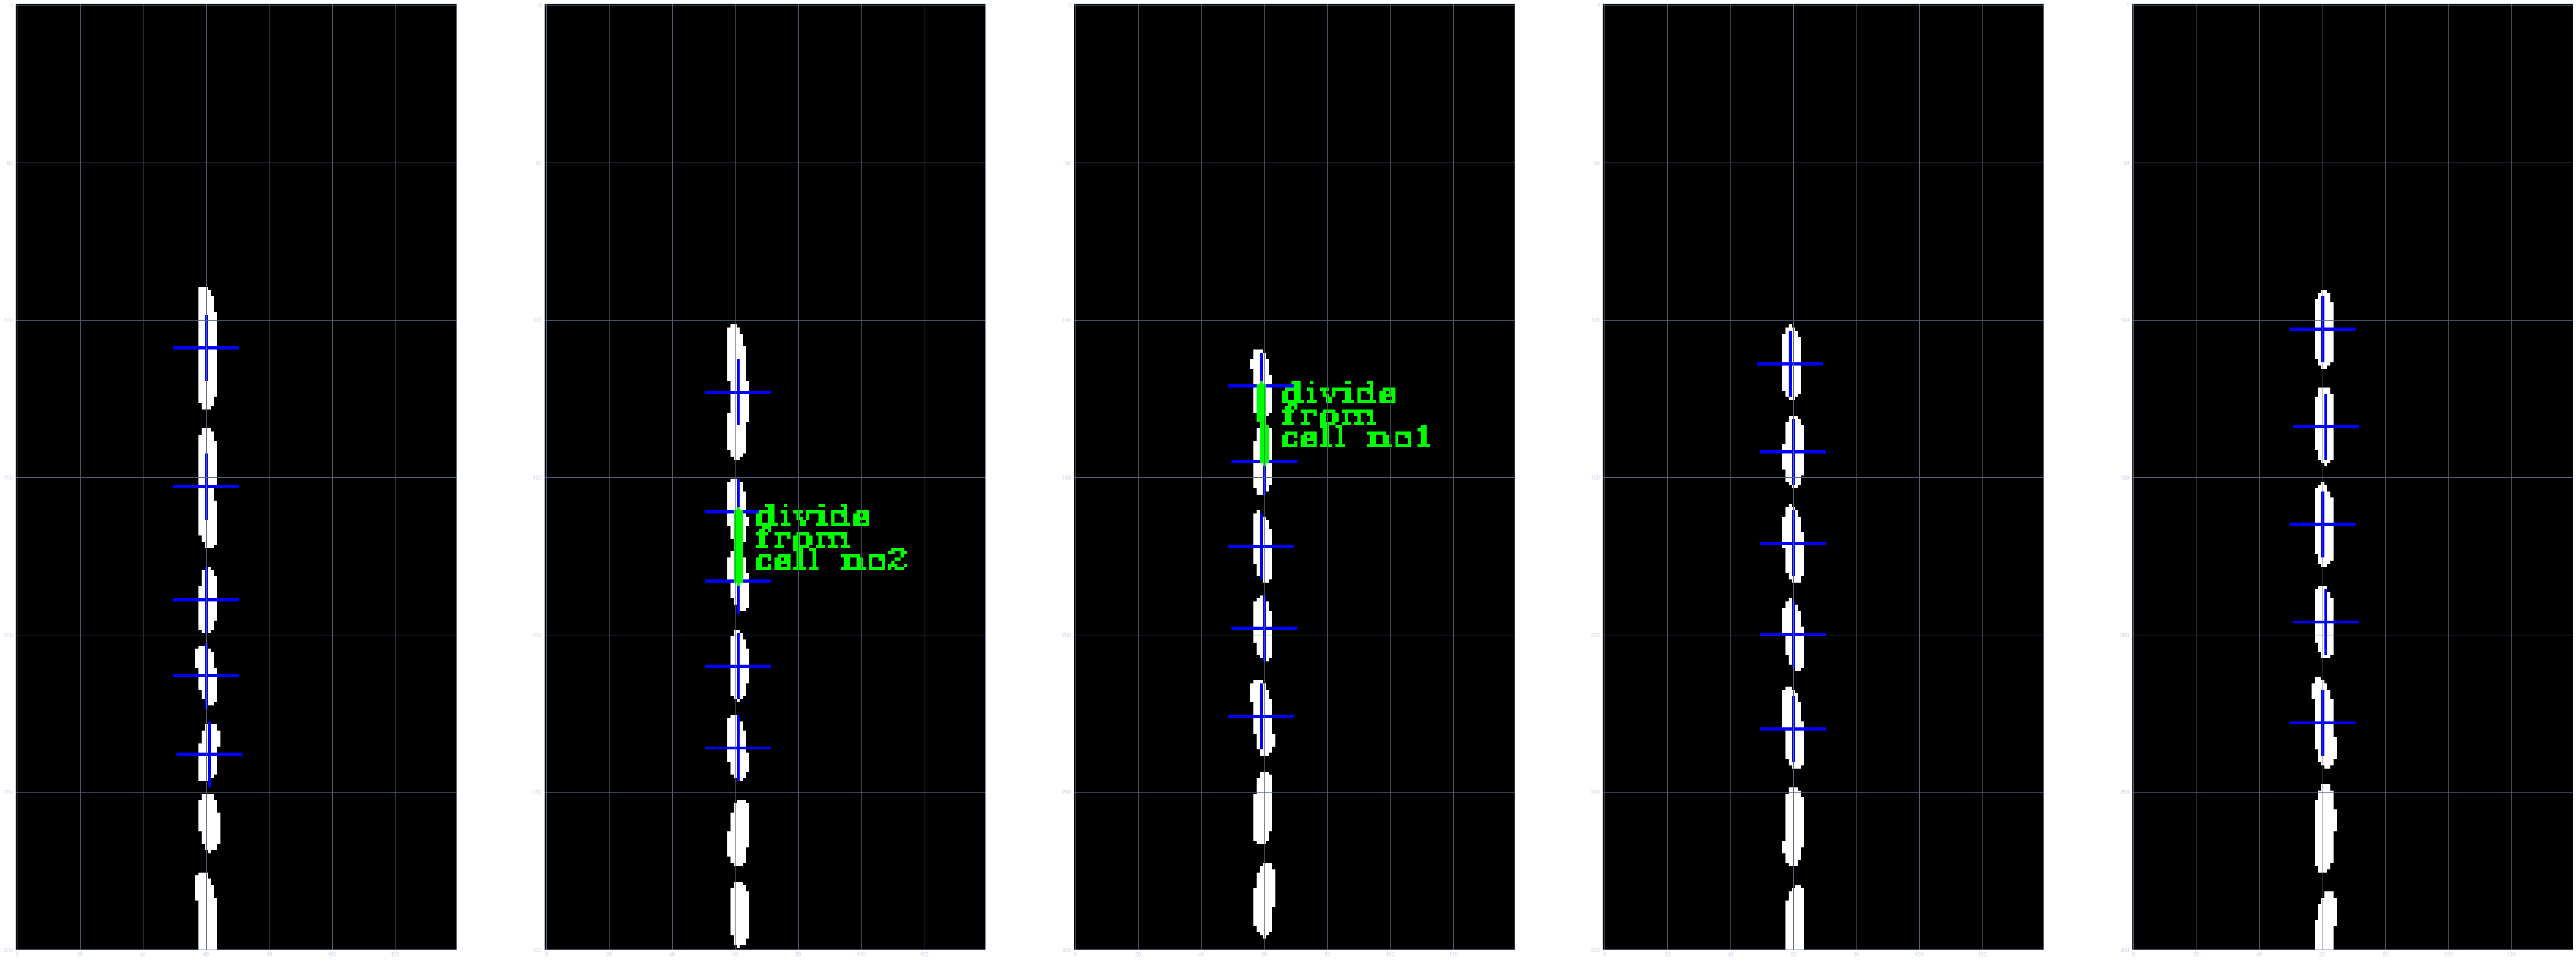

In [18]:
frames = 5

directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\labelled_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)


In [19]:
vis.label_images(mask_dir, mode="landscape", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_masks\\", template=template_mask)

saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr1_masks\landscape_masks\\landscape_xy000_mCherry_TR1_T-_epoch-20_prob-99.png


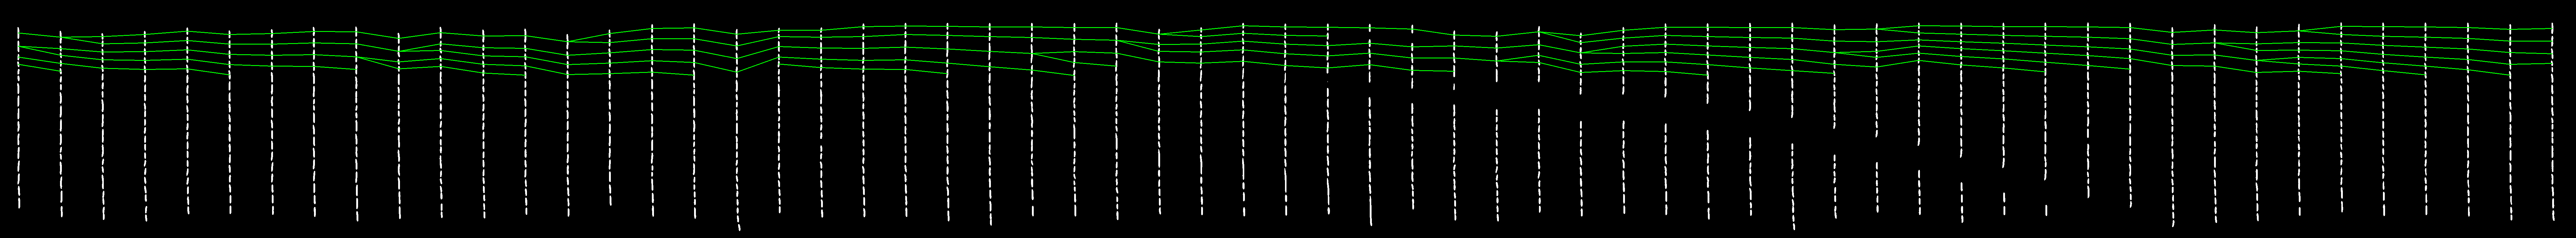

In [20]:
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))

Test it on another trench:

Tracking over frames:   2%|██▏                                                                                                                             | 1/60 [00:00<00:11,  5.20it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.34234465537457837
score: 3.947311569221892e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 2.9578355097042215e-08
score: 2.844826229123461e-12
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0293622023030141
score: 4.328490325795572e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.052238404349887524
score: 8.860887349073106e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.027167939135654868
score: 4.3541902597749615e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 9.51328178177066e-10
score: 1.259081438249813e-13
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.0

Tracking over frames:   5%|██████▍                                                                                                                         | 3/60 [00:00<00:14,  3.97it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.49177322487390474
score: 0.02236266583895942
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.004017179258745625
score: 6.808081400486534e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.010647192129647091
score: 0.00048416543983163693
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0007502117361347134
score: 1.4802751517829136e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0025090057969085287
score: 4.844208945644048e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.008106468998430262
score: 4.31311159181108e-06
the simulated scenari

Tracking over frames:   7%|████████▌                                                                                                                       | 4/60 [00:01<00:18,  3.00it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.2187203550601768
score: 8.880344261940105e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 7.433167517089166e-08
score: 2.9764212689378597e-12
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.05656271704487733
score: 4.0484278489568155e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.011410822130358319
score: 4.257409369961178e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 3.5976636890926237e-09
score: 1.9347762078788787e-13
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.08174948687343274
score: 5.4538056995600316e-05
the simulated scen

Tracking over frames:   8%|██████████▋                                                                                                                     | 5/60 [00:01<00:25,  2.18it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3468695746525131
score: 0.002858633686438234
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.09376862850034645
score: 7.820199223632227e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 3.9992000284696725e-08
score: 9.310281116016722e-11
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 4.442645990961032e-06
score: 3.981897882103107e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 2.26681989599351e-08
score: 6.302777331450648e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 

Tracking over frames:  10%|████████████▊                                                                                                                   | 6/60 [00:02<00:30,  1.79it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.15294046641613257
score: 1.191681534575065e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.23947992173829527
score: 0.0022073940111129874
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.106452541457891e-07
score: 7.271914980039733e-12
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.0139560281415695e-05
score: 4.2749017457564166e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.0383646338356057e-07
score: 1.1005485621495481e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabi

Tracking over frames:  12%|██████████████▉                                                                                                                 | 7/60 [00:03<00:31,  1.70it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47134235008303155
score: 0.008984970348070356
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.472667329206076e-06
score: 8.988390819272926e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 9.303865320370712e-07
score: 2.316678551493316e-09
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.00020206505589262543
score: 1.4291193932358881e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 2.284278082963587e-05
score: 5.755282560916611e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabil

Tracking over frames:  13%|█████████████████                                                                                                               | 8/60 [00:03<00:28,  1.85it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5323574428408084
score: 0.04269466057348157
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 2.4327856364700407e-05
score: 6.895619273910801e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.00019299084984106734
score: 4.705484490871101e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.2246029182540527e-05
score: 3.7424223887819986e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 3.914523532362265e-06
score: 1.31531127273329e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0011609777319634281
score: 5.141464442825521e-07
the simulated sce

Tracking over frames:  15%|███████████████████▏                                                                                                            | 9/60 [00:04<00:26,  1.93it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5216614281147786
score: 0.040842043051804784
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00020473455806534983
score: 4.889880351099182e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0009676430778340716
score: 2.056628495095026e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00019198259215934878
score: 4.6041285825788947e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 5.585571421411391e-05
score: 1.500403034053093e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0066431660462789675
score: 2.452319792759991e-06
the simulated sc

Tracking over frames:  18%|███████████████████████▎                                                                                                       | 11/60 [00:04<00:19,  2.50it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4818646727489382
score: 0.18757210967222618
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0011431795291765444
score: 2.8023060880151067e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.010141521124584949
score: 0.00394771939136316
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.001324643763075744
score: 3.1969680676164316e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00036569830047236565
score: 1.0810566950467146e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.01911031748203518
score: 8.351100020833831e-06
the simulated scenario

Tracking over frames:  20%|█████████████████████████▍                                                                                                     | 12/60 [00:05<00:16,  2.95it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.24843022459743502
score: 0.00791631561078488
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0015549641057292657
score: 2.506948982451275e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.011591020312107545
score: 1.4915187695949444e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.12581724893484247
score: 3.937276542685847e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.011934923831306
score: 1.572588650670543e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 2.720626168270009e-05
score: 1.222224437117948e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.00220

Tracking over frames:  22%|███████████████████████████▌                                                                                                   | 13/60 [00:05<00:14,  3.22it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.04031946549140325
score: 8.156618370797442e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.002565119585107698
score: 5.029838481091359e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.009344607224973772
score: 6.421781174381242e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.09893428461017961
score: 6.648544532899339e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.011027461446021786
score: 3.9618382931952307e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 0.00022293854887253444
score: 1.4894817056112045e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0

Tracking over frames:  23%|█████████████████████████████▋                                                                                                 | 14/60 [00:05<00:15,  3.04it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.17388537116036482
score: 0.0018016381785733913
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 3.2724328582331916e-07
score: 6.77887182282832e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.22588052075669574
score: 0.00018037417075143683
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 6.634002978115574e-07
score: 1.3682284798764997e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 2.692360169325761e-08
score: 8.192963913505969e-11
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 3.1604687236867216e-06
score: 3.446385021090381e-09
the simulated sc

Tracking over frames:  25%|███████████████████████████████▊                                                                                               | 15/60 [00:06<00:15,  2.86it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.020312671857866907
score: 3.7633394540169955e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 3.4074029640010415e-07
score: 1.6174837905001598e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.3219791088351286
score: 0.0028968803617139224
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 9.449690551092245e-07
score: 2.9717847314028443e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 5.1873249154752186e-08
score: 3.888130996670814e-12
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 2.1312360524793706e-06
score: 4.90127107285177e-11
the simulated 

Tracking over frames:  27%|█████████████████████████████████▊                                                                                             | 16/60 [00:06<00:21,  2.09it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47064100341072074
score: 0.014714671649414549
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.700500433166223e-05
score: 8.442999560199678e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0001289801375002478
score: 2.6786795635100857e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0005288251839329707
score: 2.545882547967463e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.1459999204476468e-05
score: 3.10266867972513e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabili

Tracking over frames:  28%|███████████████████████████████████▉                                                                                           | 17/60 [00:07<00:19,  2.24it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.528627718299729
score: 0.050350445813667016
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.000989308015554367
score: 2.3251260459913397e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 4.436386428092429e-05
score: 1.2902225334804154e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0009795722786694952
score: 2.545739039611487e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00013591120903487844
score: 3.4344157852133535e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0015677153298866908
score: 6.636307378295924e-07
the simulated sce

Tracking over frames:  30%|██████████████████████████████████████                                                                                         | 18/60 [00:07<00:18,  2.26it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5142334140619602
score: 0.05764936194737365
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.003529482304733353
score: 6.844690701685087e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.00036321813604207025
score: 4.071943443958452e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0026168944883515253
score: 5.292405490881998e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00084649299274923
score: 1.9659042342348767e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.005216764771580699
score: 2.7694333017315316e-06
the simulated scenari

Tracking over frames:  32%|████████████████████████████████████████▏                                                                                      | 19/60 [00:07<00:16,  2.56it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4944651320933396
score: 0.007209934596333096
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.004945416660906281
score: 6.602133962151376e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.015475657665167397
score: 1.7463376333850224e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.016122060138868584
score: 7.5741754569803925e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.015281402652849222
score: 1.7577286885339243e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 5.8042698783273633e-05
score: 2.4316709872972162e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 

Tracking over frames:  33%|██████████████████████████████████████████▎                                                                                    | 20/60 [00:08<00:14,  2.84it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.17068635185883715
score: 3.3947514962370915e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.013186177859290129
score: 2.2032567021475476e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.03778006164881521
score: 9.32649139422739e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.028083154663558714
score: 4.871719567334906e-07
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.05180974584950827
score: 0.0008562524782127574
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 0.0010944957088196824
score: 1.059877460947217e-07
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.00

Tracking over frames:  35%|████████████████████████████████████████████▍                                                                                  | 21/60 [00:08<00:15,  2.59it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.06107871895622892
score: 4.6049635696873334e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 1.903376819004225e-08
score: 8.190951467977213e-12
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.025911152072597518
score: 0.00022368471782188305
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.052632135003468465
score: 1.3126239544935938e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 4.088984466869383e-08
score: 1.8154796581127658e-11
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.04575289063940069
score: 5.065299902803148e-06
the simulated sce

Tracking over frames:  37%|██████████████████████████████████████████████▌                                                                                | 22/60 [00:09<00:15,  2.49it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0016784458072274875
score: 3.688310399191602e-08
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 3.77353867835481e-09
score: 1.4205929023308052e-13
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 5.904100071216932e-10
score: 1.2117105068246651e-14
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.02334860143664486
score: 2.368675060313994e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 8.41460325400461e-09
score: 2.3127390573690676e-13
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.013371608316396099
score: 9.57427220743078e-07
the simulated scen

Tracking over frames:  38%|████████████████████████████████████████████████▋                                                                              | 23/60 [00:09<00:16,  2.20it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4712252402262661
score: 0.005038441431665919
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 7.269274073030342e-05
score: 1.1755692382247019e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 2.6220249979979873e-06
score: 5.693680281792731e-09
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.00018413253248354767
score: 1.5412700538742814e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.6124594918668626e-05
score: 3.967364349208763e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probab

Tracking over frames:  40%|██████████████████████████████████████████████████▊                                                                            | 24/60 [00:10<00:15,  2.30it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5314835269096718
score: 0.06481539975933898
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0007211252896508966
score: 1.735978306089866e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.00015502260309293222
score: 4.5941555507046466e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.3331519457513477e-05
score: 4.74339802777056e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 4.425134142866491e-05
score: 1.3481391664595063e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0010055544095240092
score: 4.0368140416941123e-07
the simulated sc

Tracking over frames:  42%|████████████████████████████████████████████████████▉                                                                          | 25/60 [00:10<00:15,  2.32it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5183678905089908
score: 0.06030916530208829
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.003480276011570126
score: 7.067109044285658e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0010993311549976135
score: 2.532460280719366e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 5.359757407802893e-05
score: 1.5254139660627598e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00029614527530665485
score: 7.868603851727367e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.005132120200569542
score: 2.003786965970307e-06
the simulated scenar

Tracking over frames:  45%|█████████████████████████████████████████████████████████▏                                                                     | 27/60 [00:11<00:12,  2.59it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4523538555957678
score: 0.043175803088422615
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.021484935360536164
score: 3.5705768383857665e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0045323427922204455
score: 0.0004325983685237154
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00032700372082697957
score: 7.796515200621641e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0013088801939704095
score: 2.9535177224643908e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.021237505845271856
score: 8.265379392274532e-06
the simulated scen

Tracking over frames:  47%|███████████████████████████████████████████████████████████▎                                                                   | 28/60 [00:11<00:11,  2.87it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.10295141884262189
score: 1.9406593719948605e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.007296924123286211
score: 1.1862059365515801e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0020218046962497444
score: 5.103261330520141e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.048669604535410686
score: 8.343976848130538e-07
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0800931827540097
score: 0.0005933039238556631
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 5.373756243414583e-05
score: 5.426768523498601e-09
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.

Tracking over frames:  48%|█████████████████████████████████████████████████████████████▍                                                                 | 29/60 [00:11<00:11,  2.65it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.040318026429537815
score: 0.0013602902550178876
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 2.1567306558780918e-07
score: 5.839060041124738e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.019914763534914053
score: 0.0006719043853714669
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00503015121138161
score: 5.983390589454646e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.1435690924533642e-08
score: 4.0398199433001914e-11
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.1308249897969616
score: 3.057127817729328e-05
the simulated scena

Tracking over frames:  52%|█████████████████████████████████████████████████████████████████▌                                                             | 31/60 [00:12<00:13,  2.21it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4709924703452957
score: 0.003934449848990001
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 6.07428072612458e-07
score: 1.2928216892876608e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 8.283690778403276e-05
score: 1.280874818619437e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.00014552525432721578
score: 9.171136461989102e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00024127959595549766
score: 3.8225055400353813e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabil

Tracking over frames:  53%|███████████████████████████████████████████████████████████████████▋                                                           | 32/60 [00:13<00:14,  1.87it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.46717590029698064
score: 0.048804343004159596
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 2.273821807719122e-06
score: 8.262145924063073e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0004991433996285327
score: 1.1675664942745118e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0007448908692030344
score: 3.445963017292492e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.001792722591924398
score: 3.7155854503922563e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabili

Tracking over frames:  55%|█████████████████████████████████████████████████████████████████████▊                                                         | 33/60 [00:14<00:13,  1.95it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5020075340595332
score: 0.012546825601761331
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 1.9203282081771528e-05
score: 4.281799932202e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.012846803372617366
score: 1.827439948039827e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00393332448550252
score: 5.7353021234847054e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 3.969943996764917e-05
score: 8.658366460737345e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0032249939847465627
score: 1.3560207349883863e-06
the simulated scenario

Tracking over frames:  57%|███████████████████████████████████████████████████████████████████████▉                                                       | 34/60 [00:14<00:13,  1.99it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3486606941862096
score: 0.0003523449044351768
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00022371799377322917
score: 9.655203836365737e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.07661282637149089
score: 0.0016667207327045503
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.01783781482826852
score: 6.399270734810915e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00025241845353741565
score: 1.5929935109854247e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.010265211061600214
score: 1.5062957843616225e-06
the simulated scena

Tracking over frames:  58%|██████████████████████████████████████████████████████████████████████████                                                     | 35/60 [00:15<00:13,  1.89it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.35844130294532306
score: 0.026036660451441356
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0013723345426784627
score: 2.960031014413508e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 1.3445187484364328e-08
score: 9.766390713342616e-10
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.05578843691315684
score: 7.999564441523723e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0014964796295677666
score: 3.4289877293891985e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.04027659345421433
score: 1.3808712706284962e-05
the simulated scena

Tracking over frames:  62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 37/60 [00:15<00:08,  2.65it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.17308646386267285
score: 0.022952162138767288
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.001689193639509765
score: 3.1560471583357555e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0730013345256979
score: 9.048592768049237e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.07117229983025082
score: 2.2918685070043913e-05
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.002076918242609076
score: 3.853857229027033e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 0.00026716428426424487
score: 1.122205399207153e-07
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.01

Tracking over frames:  63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 38/60 [00:15<00:06,  3.15it/s]

the simulated scenario: ['SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing']
with probability: 0.0005614761263779473
score: 1.0431312923212139e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing']
with probability: 0.004122736505170874
score: 1.9593216659723417e-07
the simulated scenario: ['Growing', 'Growing', 'Divided!']
with probability: 0.00020100647938868128
score: 6.2268924405322286e-09
the simulated scenario: ['Growing', 'Divided!', 'Growing']
with probability: 0.006222646791634602
score: 2.4738124880798866e-07
the simulated scenario: ['Divided!', 'Growing', 'Divided!']
with probability: 0.0004919750584929715
score: 5.475316151186059e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing']
with probability: 0.01523029023047464
score: 3.004573125081529e-06
the simulated scenario: ['Growing', 'Divided!', 'Divided!']
with probability: 0.0007425618919510964
score: 7.488561704208492e-08
the simulated scenario: ['D

Tracking over frames:  65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 39/60 [00:16<00:08,  2.36it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47107907185203324
score: 0.005579923844022485
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 3.932949490715617e-05
score: 6.66970189563271e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 4.799132587671975e-06
score: 1.0304441059720525e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0003362580287519807
score: 1.786826533164806e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 2.709111824227642e-07
score: 7.247706972469854e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabilit

Tracking over frames:  67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 40/60 [00:17<00:10,  1.97it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4700199568274878
score: 0.03728887689048127
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00019739270109736296
score: 5.010150086586588e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 2.5611054656592382e-05
score: 7.602004950907229e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0005160888759339973
score: 2.762231857970437e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.0373018435298833e-06
score: 4.160284784171896e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabili

Tracking over frames:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 41/60 [00:17<00:10,  1.87it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5262210675300847
score: 0.03736129585405659
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0014350120672284648
score: 3.1615668029500965e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 6.113869833855118e-06
score: 1.9486314348791416e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0001507326223064054
score: 3.6557950040046665e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0011354060367635393
score: 2.4222501780933066e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0024842420139692613
score: 8.917324060246174e-07
the simulated sc

Tracking over frames:  70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 42/60 [00:18<00:09,  1.92it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.49055551374069506
score: 0.05328012228850907
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0061276604299477285
score: 1.121519433861725e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 5.132596144965644e-05
score: 5.574605576767649e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.001348534844880805
score: 2.9173409931188107e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.006533421158266078
score: 1.3155667640906558e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.012733910633524373
score: 6.213049835849801e-06
the simulated scenar

Tracking over frames:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 44/60 [00:18<00:06,  2.52it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4355201960033666
score: 0.020201502424503266
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.016749977570241437
score: 2.5260688152867984e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.006141134408775847
score: 1.0640102062933246e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.02727839913508383
score: 9.839678430429421e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.025540122563032015
score: 3.699423244396561e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 8.856982800118945e-05
score: 4.348343981352906e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.00

Tracking over frames:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 45/60 [00:19<00:05,  2.78it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.014085153123836062
score: 2.1530278532869228e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.011856772948044419
score: 3.14194350325844e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.002697275007412693
score: 3.3897240446735467e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.008004114736727339
score: 4.699286528919641e-07
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.031338198921161485
score: 0.0005172213781778203
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 0.0008514544639704591
score: 1.1839629899629976e-07
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 

Tracking over frames:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 47/60 [00:20<00:06,  2.06it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4714943987152244
score: 0.00357771502359642
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 8.894948857104126e-06
score: 1.5428230556260812e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.706982809932096e-06
score: 2.976170432954774e-09
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.6788961052791276e-05
score: 1.3984570651836757e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 7.127009954564957e-05
score: 1.1171148372350793e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probabil

Tracking over frames:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 49/60 [00:21<00:06,  1.76it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5273949523434021
score: 0.03568152832537835
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00023563415873956574
score: 5.473203081695871e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.00374659001848723
score: 7.338955166757873e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00011791119204121125
score: 3.2183356159763306e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 2.3816587575707633e-05
score: 6.977935807518162e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0003701528712780387
score: 2.08810487379132e-07
the simulated scena

Tracking over frames:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 50/60 [00:22<00:05,  1.82it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5064289503962588
score: 0.014820156406975402
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.001896033037936865
score: 3.122281366724477e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.013317522876904115
score: 1.8418954059737333e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0008041476516522764
score: 1.5161501167652217e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00015475480153732024
score: 3.3881903079718065e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.001269413129546497
score: 4.74951138771985e-07
the simulated scena

Tracking over frames:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 51/60 [00:22<00:05,  1.77it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3697994537983527
score: 0.02181707206776775
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.009592614869031426
score: 1.528685642626407e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.07463812773855315
score: 0.004403428385708781
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.004663359542446099
score: 7.704736099593652e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0004315310353479896
score: 9.320504325437351e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.006287701254400743
score: 2.9784549810362945e-06
the simulated scenario: [

Tracking over frames:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 52/60 [00:22<00:03,  2.13it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3821955873474186
score: 0.004652713913035537
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0029492333239474573
score: 4.6262500057680555e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.016304418568992212
score: 1.734254604563788e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.015436582234039122
score: 8.162350705815709e-06
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.06347047384547884
score: 6.708613949573818e-05
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 4.718022934113848e-05
score: 2.149784021803876e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.00

Tracking over frames:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 53/60 [00:23<00:02,  2.44it/s]

score: 1.1935483309875062e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Divided!']
with probability: 0.00045911633358879664
score: 1.3157461111336977e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Growing']
with probability: 0.002795655537976412
score: 4.575170682265477e-07
the simulated scenario: ['Growing', 'Divided!', 'Divided!', 'Growing']
with probability: 0.0064976874296844254
score: 4.265483448576366e-07
the simulated scenario: ['Divided!', 'Growing', 'Divided!', 'Growing']
with probability: 0.006163650909395557
score: 3.98113472641628e-07
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Divided!']
with probability: 0.0004355138405265482
score: 1.1048445824103612e-08
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Divided!']
with probability: 0.0010122251359662381
score: 1.8025215854289227e-08
the simulated scenario: ['Divided!', 'Divided!', 'Growing', 'Divided!']
with probability: 1.90810871150395e-05
score: 2.506598023

Tracking over frames:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 54/60 [00:24<00:04,  1.40it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.290851779606414
score: 0.00021653844649514606
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 4.875085585920021e-08
score: 2.313027835092782e-11
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 8.564375012305312e-07
score: 4.144279134025024e-10
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.1588766644870915e-06
score: 3.614900565825623e-10
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.10982705198441686
score: 0.0004887956284489178
the simulated scenario: ['Growing', 'Growing', 

Tracking over frames:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 55/60 [00:26<00:04,  1.09it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4160508027820686
score: 0.01622710075575554
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 3.6146869465606174e-07
score: 1.3860595607873977e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 5.549340582448993e-06
score: 1.551143449985871e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.0468624261013583e-05
score: 4.6900083460395745e-09
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 5.557163434654677e-07
score: 2.1674432633549647e-08
the simulated scenario: ['Growing', 'Growin

Tracking over frames:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 56/60 [00:26<00:03,  1.08it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.47122290328496935
score: 0.011273554392614299
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 1.4004793380955405e-05
score: 3.2153955884991644e-08
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.3923293928174845e-06
score: 3.875234415724195e-09
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 4.135603645830896e-05
score: 2.2999198747119856e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 1.0009865282585956e-05
score: 2.474154653814738e-08
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with proba

Tracking over frames:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 57/60 [00:27<00:02,  1.07it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4688465863014654
score: 0.053958673342502886
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.00011417933004724929
score: 3.233272182532654e-07
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 1.9919231570346988e-05
score: 6.235155476740988e-08
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.00030917930546609125
score: 1.6879479042943906e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00013047365194528325
score: 3.9622700359242816e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with proba

Tracking over frames:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 58/60 [00:28<00:01,  1.23it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.5278018088539114
score: 0.03571439001210331
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0006014543260048855
score: 1.3493325420307334e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.0006156026844681464
score: 1.3289464802998056e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0001375713913801695
score: 3.5528760319736597e-07
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.0010229852864556183
score: 2.2016908126667896e-06
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.0018515343146580704
score: 6.904021438272813e-07
the simulated sc

Tracking over frames:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 59/60 [00:28<00:00,  1.38it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.4922217320569812
score: 0.03856979081528408
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.0042733108144805115
score: 9.059761644173074e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.003528955155756098
score: 6.999688940137374e-06
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.0006065370317358423
score: 1.300723564580177e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.00950170773178742
score: 1.6800028594636816e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.007831488579105659
score: 2.623381357213308e-06
the simulated scenario:

Tracking over frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.04it/s]

the simulated scenario: ['SP', 'SP', 'SP', 'SP', 'SP']
with probability: 0
score: 0.0
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.3950610251481798
score: 0.012829011501515865
the simulated scenario: ['Growing', 'Growing', 'Divided!', 'Growing', 'Growing']
with probability: 0.00949180419015684
score: 1.5291851092911052e-05
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Growing', 'Divided!']
with probability: 0.019240978329067984
score: 0.000624821778335245
the simulated scenario: ['Growing', 'Divided!', 'Growing', 'Growing', 'Growing']
with probability: 0.002703561463679748
score: 4.452430923263492e-06
the simulated scenario: ['Growing', 'Growing', 'Growing', 'Divided!', 'Growing']
with probability: 0.02585730450387761
score: 3.4701449710294494e-05
the simulated scenario: ['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']
with probability: 0.020510004564318878
score: 7.27552281324039e-06
the simulated scenario: ['

saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr2_masks\landscape_masks\\landscape_xy000_mCherry_TR2_T-_epoch-20_prob-99.png


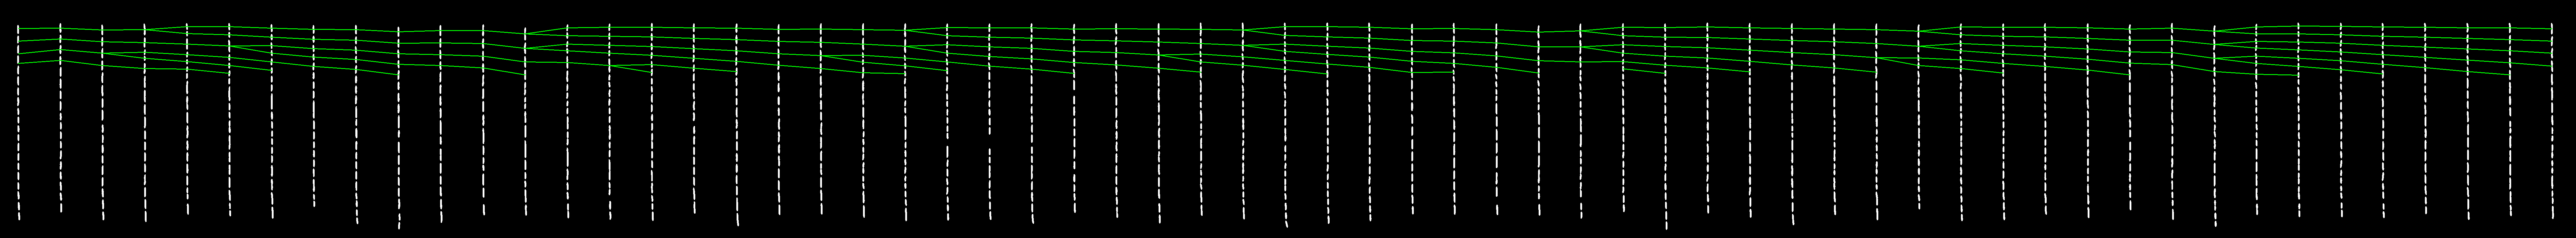

In [21]:
track_df_2, lysis_df_2 = exp.track_trench(trench=2, threshold=250, max_dpf=3, mode="SeqMatch", p_sp=0, special_reporter=None, show_details=False, ret_df=True)
vis_2 = Visualiser("000", track_df_2, lysis_df_2)
mask_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\"
vis_2.label_images(mask_dir, mode="landscape", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\landscape_masks\\", template=template_mask)
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\landscape_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))